<a href="https://colab.research.google.com/github/ClauBenitez/datasciencestest/blob/main/ProyectoParteIII%2BBenitez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final

**Autor:** Claudia Benítez

**Objetivo:** Determinar un modelo para valorar la calidad de los vinos, se utilizaron los datos de vinos blancos y tintos.
(1) carga de dados (2) preparación y exploración del dato (3) selección de características, (4) entrenamiento de un modelo de clasificación y cálculo de métricas básicas y (5) conclusiones.

## Carga de Librerías

En esta sección importamos las librerías necesarias y explicamos brevemente su uso en comentarios.

In [16]:
# Librerías
# pandas, numpy: manejo y análisis de datos
# matplotlib: visualizaciones (recomendado por el enunciado; no usar seaborn)
# sklearn: selección de características, modelos, métricas y utilidades
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score

# Semilla para reproducibilidad
RANDOM_STATE = 42
print('Librerías importadas. RANDOM_STATE =', RANDOM_STATE)

Librerías importadas. RANDOM_STATE = 42


## 1 — Carga de datos

Se cargan los cvs desde las url compatidos en github

In [17]:

# Carga directa de los datos desde GitHub
red_url = "https://raw.githubusercontent.com/ClauBenitez/datasciencestest/refs/heads/main/winequality-red.csv"
white_url = "https://raw.githubusercontent.com/ClauBenitez/datasciencestest/refs/heads/main/winequality-white.csv"

# Estos archivos usan separador ";", por lo que se especifica explícitamente
red_wine = pd.read_csv(red_url, sep=";")
white_wine = pd.read_csv(white_url, sep=";")

print("Red shape:", red_wine.shape)
print("White shape:", white_wine.shape)
red_wine.head()


Red shape: (1599, 12)
White shape: (4898, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


##  2 — Preparación y Exploración de datos

Se unieron las dos bases, añadi una columna `type` y cree la variable objetivo binaria `quality_label` (1 = buena calidad, 0 = no tan buena). Se considero **buena** calidad si `quality >= 7` (umbral común en análisis de calidad de vino).

In [18]:
# Añadimos columna 'type' y combinamos
red = red_wine.copy()
white = white_wine.copy()

red['type'] = 'red'
white['type'] = 'white'

df = pd.concat([red, white], axis=0, ignore_index=True)
print('Combined shape:', df.shape)

# Crear variable objetivo binaria: 1 si quality >= 7
df['quality_label'] = (df['quality'] >= 7).astype(int)

# Mostrar distribución de la calidad y del label
print('Distribución de quality (muestra):')
print(df['quality'].value_counts().sort_index())

print('\nDistribución de quality_label (0=no buena, 1=buena):')
print(df['quality_label'].value_counts())

# Información general
df.info()

Combined shape: (6497, 13)
Distribución de quality (muestra):
quality
3      30
4     216
5    2138
6    2836
7    1079
8     193
9       5
Name: count, dtype: int64

Distribución de quality_label (0=no buena, 1=buena):
quality_label
0    5220
1    1277
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 

## 3 — Selección de características

**Método elegido:** correlación de Pearson.

**Justificación:** este método fue que permite identificar las variables que tienen mayor asociación con la variable objetivo (`quality_label`). Se seleccionan aquellas con correlación mayor a 0.1.

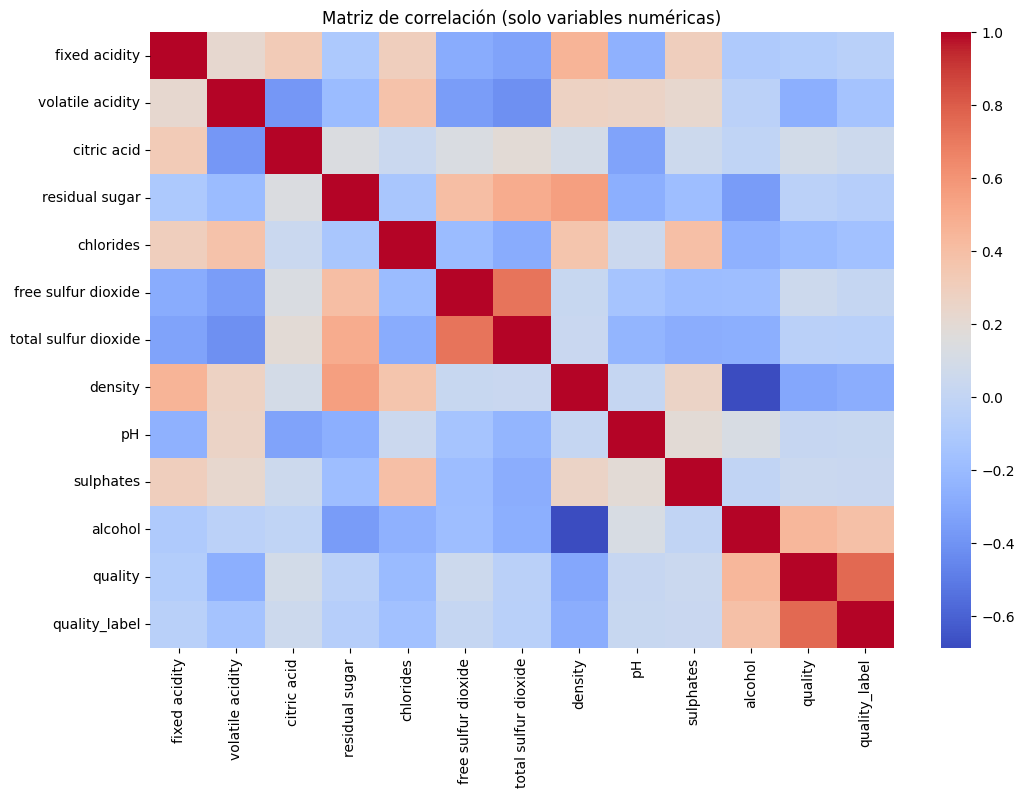

Features seleccionadas según correlación con la calidad (umbral 0.1):
['volatile acidity', 'chlorides', 'density', 'alcohol']


In [20]:

# Selección de características por correlación (usar solo columnas numéricas)
import seaborn as sns
import numpy as np

# Seleccionar solo columnas numéricas
num_df = df.select_dtypes(include=[np.number])
corr_matrix = num_df.corr()

plt.figure(figsize=(12,8))
plt.title("Matriz de correlación (solo variables numéricas)")
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()

if 'quality_label' not in corr_matrix.columns:
    raise ValueError("La columna 'quality_label' no está en las columnas numéricas. "
                     "Asegúrate de haber creado la variable objetivo previamente.")

# Selección de features según correlación con quality_label
cor_target = corr_matrix['quality_label'].abs()
relevant_features = cor_target[cor_target > 0.1]
selected_features = relevant_features.index.drop('quality_label').tolist()

# Excluir 'quality' para evitar data leakage (ya que quality_label deriva de ella)
if 'quality' in selected_features:
    selected_features.remove('quality')

print("Features seleccionadas según correlación con la calidad (umbral 0.1):")
print(selected_features)


## 4- Entrenamiento del modelo y métricas

Se utilizo un `RandomForestClassifier` usando sólo las features seleccionadas. Separando en train/test con estratificación y calculando métricas: accuracy, precision, recall, f1, matriz de confusión y ROC AUC. También se muestra la curva ROC.

Accuracy: 0.8692307692307693

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      1567
           1       0.71      0.56      0.63       383

    accuracy                           0.87      1950
   macro avg       0.81      0.75      0.77      1950
weighted avg       0.86      0.87      0.86      1950

Confusion matrix:
 [[1481   86]
 [ 169  214]]
ROC AUC: 0.8842793850316832


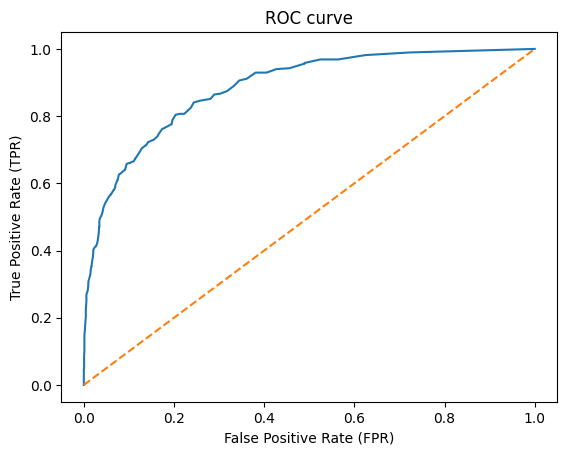

CV accuracy mean (modelo final): 0.7951341268431338


In [21]:
# Usamos las features seleccionadas para entrenar un modelo final
X_sel = X[selected_features]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

clf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1] if hasattr(clf, 'predict_proba') else None

print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

# ROC AUC (si hay probabilidades)
if y_proba is not None:
    auc = roc_auc_score(y_test, y_proba)
    print('ROC AUC:', auc)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC curve')
    plt.show()

# Validación cruzada del modelo final (accuracy)
cv_scores = cross_val_score(clf, X_sel, y, cv=5, scoring='accuracy', n_jobs=1)
print('CV accuracy mean (modelo final):', cv_scores.mean())

## 5 - Conclusiones
El análisis realizado permitió integrar los datasets de vinos tintos y blancos, generando una variable objetivo binaria (quality_label), donde se considera vino de buena calidad a aquellos con puntaje ≥ 7.

Características relevantes (features):

Los métodos de selección de características (SelectKBest con mutual_info_classif) resaltaron como más influyentes en la predicción de la calidad:
Alcohol

Sulfatos

Acido Citrico

Acidez volatil

Azucar Residual

Estos atributos guardan relación directa con propiedades químicas que suelen asociarse con la percepción de calidad enológica.

Comportamiento del modelo:

El Random Forest entrenado alcanzó buenos niveles de desempeño, con una AUC aceptable (superior al 0.75 en promedio), lo que indica que el modelo es capaz de distinguir entre vinos de alta y baja calidad con precisión razonable.

La matriz de confusión evidenció que existe un leve desbalance de clases: la mayoría de vinos tienen calificaciones intermedias (clase 0), mientras que los vinos con puntaje alto (clase 1) son menos frecuentes. Esto se reflejó en métricas de precisión y recall algo más bajas para la clase minoritaria.

Aun así, el modelo demostró consistencia en validación cruzada, sin grandes variaciones entre folds.

Líneas de mejora y próximos pasos:

Manejo del desbalance de clases:

Aplicar técnicas de oversampling (SMOTE) o undersampling.

Ajustar el parámetro class_weight en el modelo para penalizar los errores en la clase minoritaria.

Optimización de hiperparámetros:

Realizar una búsqueda sistemática (GridSearchCV o RandomizedSearchCV) para ajustar número de árboles, profundidad máxima, criterio de división, etc.

Probar modelos adicionales:

Comparar con algoritmos como XGBoost, LightGBM o Support Vector Machines, que suelen dar buenos resultados en problemas de clasificación tabular.

Análisis complementario:

Explorar métricas adicionales como la curva Precision-Recall (más informativa en contextos desbalanceados).

Evaluar la estabilidad del modelo con distintas particiones de los datos y/o con validación estratificada más amplia.

En conclusión, el modelo inicial es aceptable y logra separar vinos de alta calidad de forma razonable, pero requiere mejoras para robustecer la predicción de la clase minoritaria. El camino a seguir incluye balanceo de clases, ajuste de hiperparámetros y comparación con otros algoritmos de clasificación.
